# ICDM Proposed Reward Distributions

Developers of the NFT project, Internet Computer Personal Computers, have recently set a vote to allow the community to decide a reward mechanism for holders.  Each month, 5% of the secondary market trades will be allocated to a pool and disbursed to holders in one of two ways.  The two options are:

* A: ICP tokens paid out based on your weighted stake
    * weight calculated as `7777 * 2 * NRI (NFT Rarity) + 7777`
    * payout proportional to your share of the total stake, or the sum of your weighted scores for each NFT
* B : Raffle entries for weighted stake
    * same weight calc as above, allocated as "tickets" and a multiplier is applied for number held in the same wallet (instead of sum)
    * by winning the drawing your ticket allocation for the next round is halved
    * all losers' ticket allocations are multiplied by 1.5 for the next round
    * ticket amounts compound, accruing across rounds
    * number of NFT's awarded are based on the pool allocation from a 5% tax on all transactions, with the devs buying as many as possible at the current floor

I thought this might be an interesting opportunity to see what the odds were based on actual wallet data. I also suggested a different formula whcih I believed might be a little fairer: `Mean NRI score * (# NFTs / 7777) * Number of consecutive raffle periods` with the idea being more emphasis is placed on holding a larger number of more rare NFT's and receiving a greater bonus for participating in consecutive rounds.  My major concern was with Whale wallets being able to unfairly game the system by playing with the probabilities of winning and statistically guaranteeing no one else wins.  Below I'll explore that idea by scraping current ICPC wallet data from DGastonia.com, running a 5 year simulation, and plotting the odds of victory with a few assumptions:
* highest probability wins that round
* awarded NFT's are not added to the winner's wallet (estimating NFT rewards would be hard with limited history)
* ALL NFT's in each wallet are staked

Basically, taking a snapshot in time, how long would it take for the game to become fair for all players?

### Building the dataset

BeautifulSoup and Pandas will help to pull in the data as we have most of what we need on dgastonia, number of holdings and the TI^ (probability of minting with those traits) that each wallet holds.  Unfortunately I am not sure on how to actually pull this data directly from the ICP blockchain, but I hope in the future to learn and potentially iterate on this project!

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import sqlite3
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

url = 'https://www.dgastonia.com/nfts/collections/icpcs/registry'

page = requests.get(url)

soup = BeautifulSoup(page.content, "html.parser")

### Account Holdings

We can start by fetching a summary of account holdings from dgastonia, thankfully this is formatted already pretty nicely so it will be easy to scrape into a single dataframe.  

In [2]:
# get holdings by account
table = soup.table.prettify()
accounts = pd.read_html(table)[0]
accounts

,Account,Count,Percent,Floor value
0,…ff2188,202,2.6%,545.4
1,…d4010e,197,2.53%,531.9
2,…87339d,167,2.15%,450.9
3,…77b94d,151,1.94%,407.7
4,…d23f51,135,1.74%,364.5
...,...,...,...,...
1292,…353906,1,0.01%,2.7
1293,…e7adbd,1,0.01%,2.7
1294,…931ae4,1,0.01%,2.7
1295,…1ccc40,1,0.01%,2.7


### Average Rarity

Next we need to pull in the average rarity by wallet holding. This will be a little bit trickier to do as the metric used on Entrepot, NRI (NFT Rarity Index) is not easily accessible nor used on the site we're scraping.  Instead we have DTI (Dominant Trait Index), TI (Trait Index) and TI^ (Exponential Trait Index).  Given each of these metrics is a little different, and differs from NRI, we can collect each of these and then use the metric we feel is most closely related to what we're measuring.  Since TI^ is the statistical proability of minting the NFT with those traits, we can use that as a proxy until I can pull in NRI reliably.  

Given there are no `id` or `class` attributes in the HTML being scraped, we can use the fact that all three metrics will be pulled into a single list and then use mod 3 on the index of the value in the list to categorize them into their respective metric buckets (first is DTI, second is TI, third is TI^ and then it repeats).  

In [3]:
# get average rarity by account
base_url = 'https://www.dgastonia.com'

def get_rarity(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    rarity_list = soup.find_all('span','percentIndex')
    rarities = []
    for x in rarity_list:
        rarities.append(float(x.text))
    return rarities

In [6]:
avg_nri = {}
for i, account in enumerate(soup.table.find_all('a')): # find all links in the table
    account_link = base_url + account.attrs.get('href') # get reference links to unique wallet pages
    all_rarities = []
    page = 1 # initialize page 1
    while True:
        if page == 1:
            all_rarities += get_rarity(account_link)
            page += 1
        elif page != 1:
            next_page = account_link + f'&page={page}' # add page 2+ to URL 
            next_rarity = get_rarity(next_page)            
            if next_rarity == []: # exit loop if no data found on page
                break
            all_rarities += next_rarity
            page += 1
                    
    dti = []
    ti = []
    ti_exp = []
    for index, value in enumerate(all_rarities):
        if index % 3 == 0:
            dti.append(value)
        elif index % 3 == 1:
            ti.append(value)
        else:
            ti_exp.append(value)
            
    acc_no = account.text.strip()
    avg_nri[acc_no] = {
        'dti': np.mean(dti),
        'ti': np.mean(ti),
        'ti_exp': np.mean(ti_exp)
    }
    print(f'pages parsed: {(page-1)} for account: {acc_no}, {i / (len(accounts)-1):.2%} finished', end='\r')

In [7]:
# assign ti_exp to a dict by acct
avg_ti_exp = {v: avg_nri[v]['ti_exp'] for v in avg_nri}

In [8]:
nri_df = pd.DataFrame.from_dict(avg_ti_exp, orient='index').reset_index()
nri_df.rename(columns = {
    "index":"Account",
    0:"Mean NRI"
}, inplace=True)
nri_df

holders = pd.merge(accounts, nri_df, on='Account')

# create initial ticket values based on dev formula
def init_tickets(df):
    return (7777*2*df[1]+7777)*df[0]

# create proposed ticket values based on my formula
def proposed_tickets(df): 
    return (df[1] * (df[0]/7777))

# apply to create new column
holders['Initial Tickets'] = holders[['Count','Mean NRI']].apply(init_tickets,axis=1)
holders['Proposed Tickets'] = holders[['Count','Mean NRI']].apply(proposed_tickets,axis=1)
holders

,Account,Count,Percent,Floor value,Mean NRI,Initial Tickets,Proposed Tickets
0,…ff2188,202,2.6%,545.4,47.296040,1.501708e+08,1.228469
1,…d4010e,197,2.53%,531.9,39.980102,1.240366e+08,1.012740
2,…87339d,167,2.15%,450.9,45.120958,1.185013e+08,0.968908
3,…77b94d,151,1.94%,407.7,59.053642,1.398709e+08,1.146599
4,…d23f51,135,1.74%,364.5,53.389552,1.131567e+08,0.926783
...,...,...,...,...,...,...,...
1292,…353906,1,0.01%,2.7,68.600000,1.074781e+06,0.008821
1293,…e7adbd,1,0.01%,2.7,82.300000,1.287871e+06,0.010582
1294,…931ae4,1,0.01%,2.7,5.600000,9.487940e+04,0.000720
1295,…1ccc40,1,0.01%,2.7,29.300000,4.635092e+05,0.003768


In [30]:
# store data in SQL file for easier access, refresh the db
db = os.path.join(os.getcwd(), 'holders.sqlite3')
con = sqlite3.connect(db)
holders.to_sql('holders',con,if_exists="replace",index=False) 

1297

In [25]:
# run from this cell down instead of re-scraping every time.
db = os.path.join(os.getcwd(), 'holders.sqlite3')
con = sqlite3.connect(db)
holders = pd.read_sql("SELECT * FROM holders",con=con)
con.close()
holders.head(20)

,Account,Count,Percent,Floor value,Mean NRI,Initial Tickets,Proposed Tickets
0,…ff2188,202,2.6%,545.4,47.296040,1.501708e+08,1.228469
1,…d4010e,197,2.53%,531.9,39.980102,1.240366e+08,1.012740
2,…87339d,167,2.15%,450.9,45.120958,1.185013e+08,0.968908
3,…77b94d,151,1.94%,407.7,59.053642,1.398709e+08,1.146599
4,…d23f51,135,1.74%,364.5,53.389552,1.131567e+08,0.926783
5,…836d79,113,1.45%,305.1,61.676991,1.092824e+08,0.896168
6,…362777,106,1.36%,286.2,29.909434,5.013676e+07,0.407664
7,…358e40,99,1.27%,267.3,61.274747,9.512360e+07,0.780018
8,…23cc44,92,1.18%,248.4,47.465217,6.863669e+07,0.561502
9,…e06d13,90,1.16%,243.0,52.962222,7.483963e+07,0.612910


## Ticket Values by Account

Below is a chart showing the initial ticket amounts for each account, sorted descending by number of NFT's in account.  This should give an idea of how the tickets are distributed across different holders.  It's important to keep in mind that one individual is likely to hold their NFT's across several wallets, which may even allow them to game the raffle down the line.

Text(0.5, 1.0, 'Distribution of Ticket Amounts by Account')

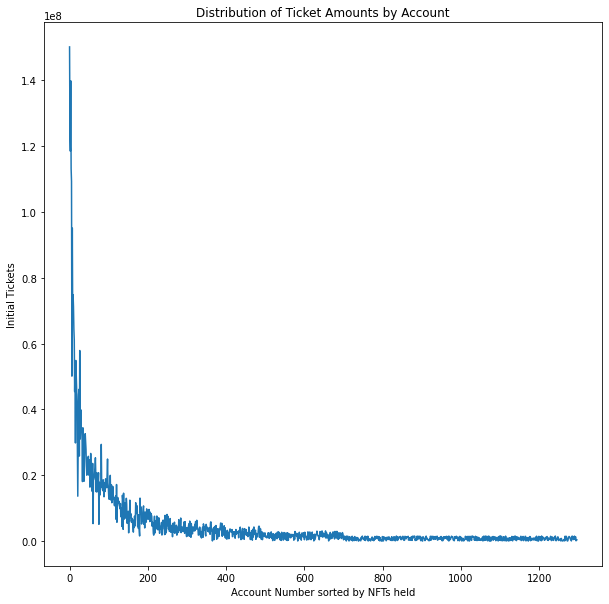

In [40]:
%matplotlib inline
plt.figure(figsize=(10,10))
sns.lineplot(x=holders.index,y=holders['Initial Tickets'])
plt.xlabel('Account Number sorted by NFTs held')
plt.title('Distribution of Ticket Amounts by Account')

## Simulating Raffle Game

To simulate this, we will create a function applied to a sliding window of time where each row represents a new monthly raffle and each column is a unique wallet address.  To reiterate how this simulation works which may differ from reality, here are some assumptions:
* only one wallet wins
* the highest probability wins
* NFT's are not added to the winner's staked pool
* the entire wallet holding is staked

The model will be run for a 5 year timeframe and we should be able to extract the point at which probabilities of winning converge so that all participants have an equal chance of winning.  We should also be able to extract the rate at which wallets converge based on number of NFT's held and their average rarity. 

In [8]:
# transpose tickets to act as starting cols for each ruleset

rulesets = ['initial','proposed']

def run_sim(df, ruleset):
    """
    Takes DataFrame of Accounts and returns 60 drawings based on
    the calculation used (original dev plan or my proposed plan)
    """
    sim = pd.DataFrame(index=range(60), columns=df['Account'])
    
    if ruleset == 'initial':
        i_tix = df['Initial Tickets']
    else:
        i_tix = df['Proposed Tickets']
    
    # initial ticket values by wallet
    sim.iloc[0] = i_tix
    
    # return 1.5x multiplier for all holders (50% rollover) and cut winner's odds in half
    for i in range(59):
        sim.iloc[i+1] = sim.iloc[i] * 1.5
        sim.iloc[i+1] = sim.iloc[i+1].apply(lambda x: x / 3 if x == max(sim.iloc[i+1]) else x)
    
    # by row convert values to winning odds
    for i in range(60):
        sim.iloc[i] = sim.iloc[i].apply(lambda x: (x / sum(sim.iloc[i])*100))
    
    return sim

initial_probability = run_sim(holders,'initial')
proposed_probability = run_sim(holders, 'proposed')

proposed_probability.head()

Account,…ff2188,…d4010e,…87339d,…77b94d,…d23f51,…836d79,…362777,…358e40,…23cc44,…e06d13,...,…1e3d8c,…02666f,…6980bb,…fee86a,…b662df,…353906,…e7adbd,…931ae4,…1ccc40,…5284e1
0,2.456144,2.024827,1.937191,2.292458,1.852967,1.791758,0.815064,1.559533,1.122641,1.225424,...,0.00761,0.014911,0.008689,0.02504,0.010155,0.017636,0.021158,0.00144,0.007533,0.006376
1,0.832344,2.058534,1.96944,2.33062,1.883814,1.821585,0.828632,1.585494,1.14133,1.245824,...,0.007736,0.015159,0.008834,0.025457,0.010324,0.01793,0.02151,0.001464,0.007658,0.006482
2,0.84548,2.091023,2.000523,0.789135,1.913545,1.850335,0.84171,1.610517,1.159343,1.265486,...,0.007859,0.015398,0.008974,0.025859,0.010487,0.018213,0.02185,0.001487,0.007779,0.006584
3,0.857433,0.706861,2.028804,0.800291,1.940597,1.876493,0.85361,1.633286,1.175733,1.283377,...,0.00797,0.015616,0.0091,0.026224,0.010635,0.01847,0.022159,0.001508,0.007889,0.006677
4,0.869189,0.716553,0.68554,0.811263,1.967205,1.902222,0.865314,1.655679,1.191853,1.300973,...,0.008079,0.01583,0.009225,0.026584,0.010781,0.018723,0.022463,0.001528,0.007997,0.006769


<AxesSubplot:>

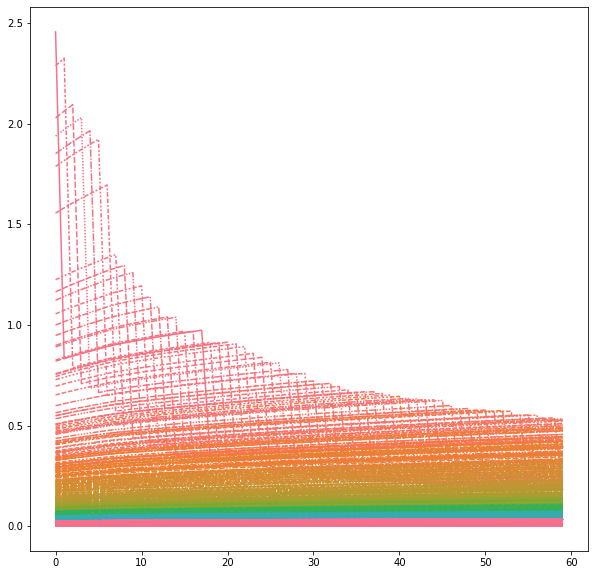

In [65]:
%matplotlib inline

#plot the min, 25%, 50%, 75%, and largest holder over the course of the sim
def sample_accounts(holders):
    _min = holders[holders['Initial Tickets'] == holders['Initial Tickets'].min()]['Account'].values[0]
    _25th = holders[holders.index == round(len(holders)*.25)]['Account'].values[0]
    _50th = holders[holders.index == round(len(holders)*.5)]['Account'].values[0]
    _75th = holders[holders.index == round(len(holders)*.75)]['Account'].values[0]
    _max = holders[holders['Initial Tickets'] == holders['Initial Tickets'].max()]['Account'].values[0]
    return _min, _max, _25th, _50th, _75th
l,h,t,f,s = sample_accounts(holders)
plt.figure(figsize=(10,10))
plt.plot(initial_probability.median(axis=1))
sns.lineplot(data=initial_probability.iloc[:,:],legend=False)